In [19]:
from os import listdir
from numpy import asarray
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Resizing
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# Load all the images from a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	# Enumerate filenames in directory
	for filename in listdir(path):
		# Loading and resizing the images
		pixels = load_img(path + filename, target_size=size)
		# Converting each image to a numpy array
		pixels = img_to_array(pixels)
		# Storing the images
		data_list.append(pixels)
	return asarray(data_list)

In [3]:
# Dataset path
path = 'monet2photo/'

# Load dataset A - Monet paintings
dataA_all = load_images(path + 'trainA/')
print('Loaded dataA: ', dataA_all.shape)

from sklearn.utils import resample
# Getting a subset of all images (for faster training during demonstration)
dataA = resample(dataA_all, 
                 replace=False,     
                 n_samples=300,    
                 random_state=42) 

# Load dataset B - Real photos 
dataB_all = load_images(path + 'trainB/')
print('Loaded dataB: ', dataB_all.shape)

# Getting a subset of all images (for faster training during demonstration)
dataB = resample(dataB_all, 
                 replace=False,     
                 n_samples=400,    
                 random_state=42) 

Loaded dataA:  (1072, 256, 256, 3)
Loaded dataB:  (6287, 256, 256, 3)


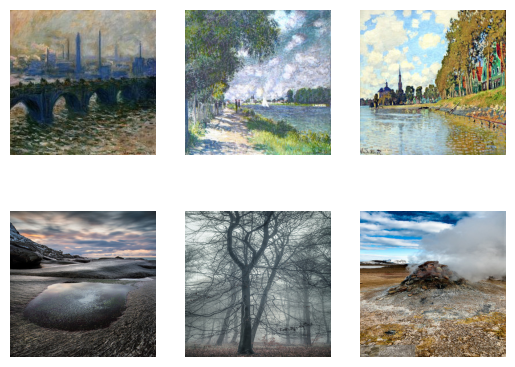

In [4]:
# Plot source images
n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(dataA[i].astype('uint8'))

# Plot target image
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(dataB[i].astype('uint8'))


In [5]:
# Load images data
data = [dataA, dataB]

print('Loaded', data[0].shape, data[1].shape)

Loaded (300, 256, 256, 3) (400, 256, 256, 3)


In [6]:
# Preprocess data to change input range to values between -1 and 1. This is because the generator uses tanh activation in the output layer
def preprocess_data(data):
	# Loading compressed arrays and unpack them
	X1, X2 = data[0], data[1]
	# Scaling from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)

In [8]:
from cycleGAN_model import define_generator, define_discriminator, define_composite_model, train
# Define the input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# A → B generator 
g_model_AtoB = define_generator(image_shape)
# B → A generator
g_model_BtoA = define_generator(image_shape)
# A → [real/fake] discriminator
d_model_A = define_discriminator(image_shape)
# B → [real/fake] discriminator
d_model_B = define_discriminator(image_shape)
# Composite A → B → [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# Composite B → A → [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

c:\Users\Yago\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Yago\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If yo

In [10]:
from datetime import datetime 
start1 = datetime.now() 
# Train all models
losses = {'dA1': [], 'dA2': [], 'dB1': [], 'dB2': [], 'g1': [], 'g2': []}
training = train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, losses, epochs=10)

stop1 = datetime.now()
execution_time = stop1 - start1
print("Execution time is: ", execution_time)

1/1 [==============================] - 0s 19ms/step
Iteration>1, dA[5.724,1.415] dB[16.470,1.026] g[17.852,17.113]
1/1 [==============================] - 0s 18ms/step
Iteration>2, dA[7.519,1.422] dB[5.931,0.759] g[17.218,18.413]
1/1 [==============================] - 0s 19ms/step
Iteration>3, dA[4.563,1.191] dB[1.881,1.037] g[18.041,20.051]
1/1 [==============================] - 0s 20ms/step
Iteration>4, dA[1.640,1.839] dB[1.158,1.082] g[16.594,17.071]
1/1 [==============================] - 0s 19ms/step
Iteration>5, dA[1.140,4.183] dB[2.387,1.489] g[17.578,18.720]
1/1 [==============================] - 0s 22ms/step
Iteration>6, dA[0.990,2.391] dB[4.620,3.385] g[18.414,20.443]
1/1 [==============================] - 0s 23ms/step
Iteration>7, dA[1.356,1.329] dB[2.965,3.064] g[14.840,15.747]
1/1 [==============================] - 0s 25ms/step
Iteration>8, dA[3.802,2.099] dB[4.405,2.143] g[14.180,16.818]
1/1 [==============================] - 0s 24ms/step
Iteration>9, dA[2.784,0.722] dB[1.3

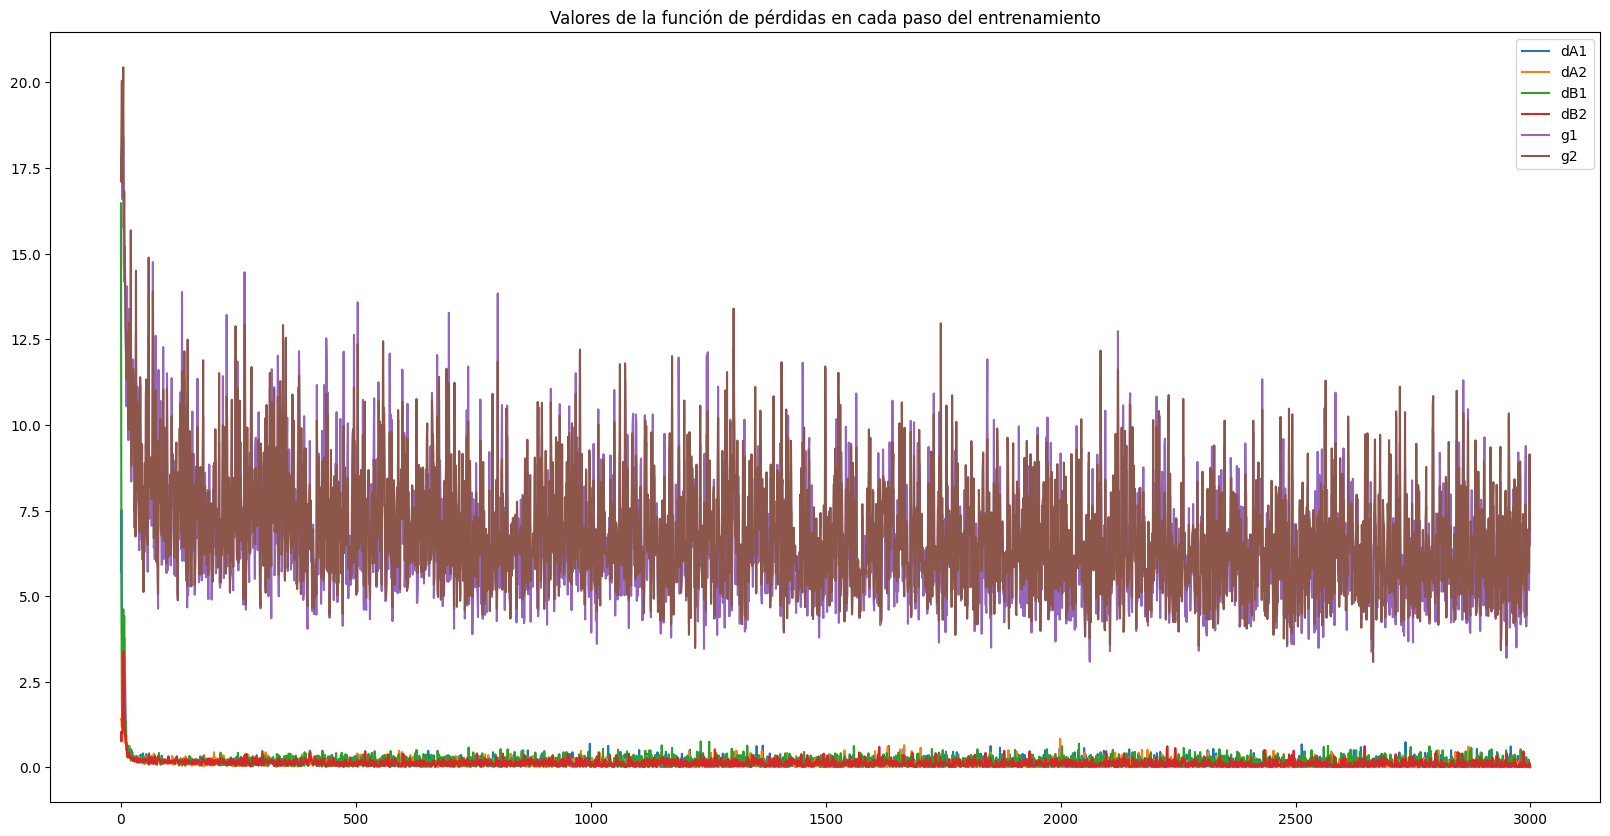

In [22]:
plt.figure(figsize=(20, 10))
for l in losses.keys():
    plt.plot(losses[l], label=l)
    plt.legend()
plt.title('Valores de la función de pérdidas en cada paso del entrenamiento');

In [16]:
# Use the saved CycleGAN models for image translation
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from numpy.random import randint

# Select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# Choosing random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# Retrieving selected images
	X = dataset[ix]
	return X

# Plot the image, its translation and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# Scaling from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# Plotting images row by row
	plt.figure(dpi=200)  # Change DPI as required
	for i in range(len(images)):
		plt.subplot(1, len(images), 1 + i)
		plt.imshow(images[i])
		plt.title(titles[i])
		plt.axis('off')
	plt.show()

c:\Users\Yago\anaconda3\envs\tf_gpu\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 598ms/step


1/1 [==============================] - 1s 637ms/step


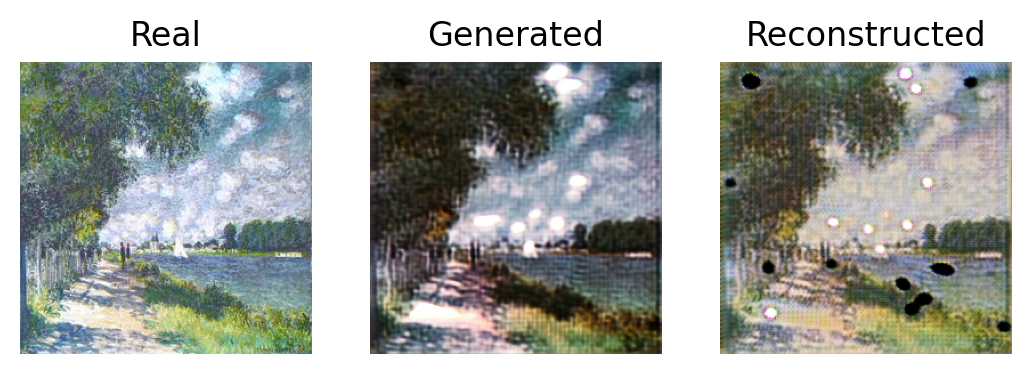

1/1 [==============================] - 0s 30ms/step


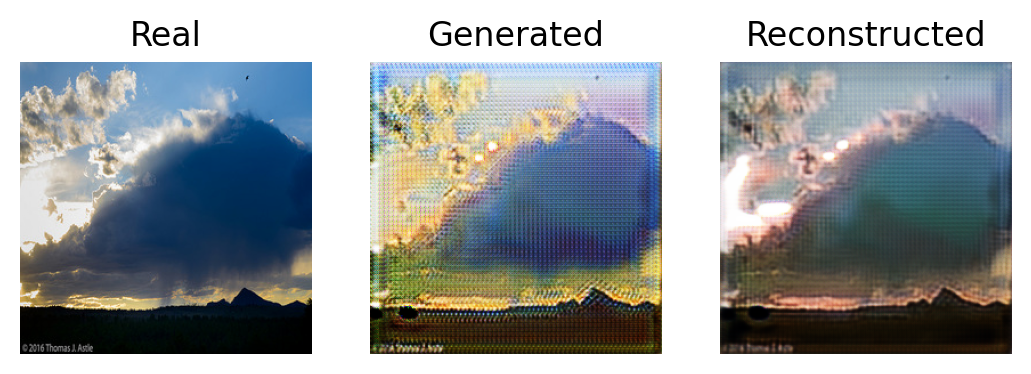

1/1 [==============================] - 0s 28ms/step


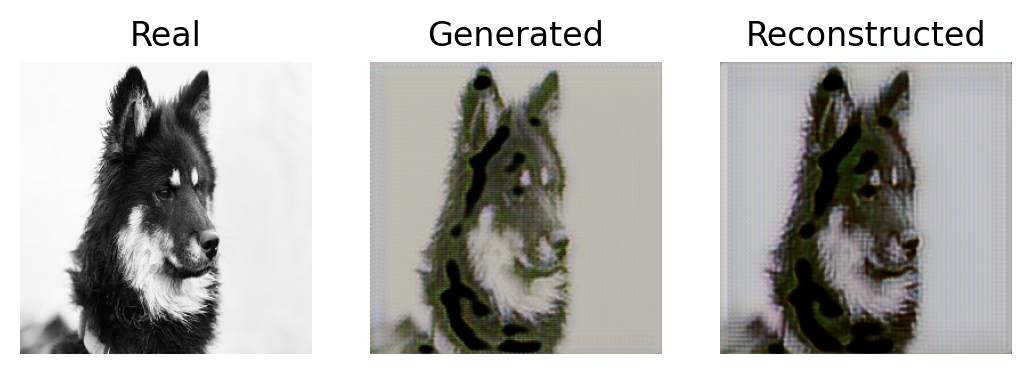

In [20]:
# Load dataset
A_data = resample(dataA_all, 
                 replace=False,     
                 n_samples=4,    
                 random_state=42) # For reproducible results

B_data = resample(dataB_all, 
                 replace=False,     
                 n_samples=4,    
                 random_state=42) # For reproducible results

A_data = (A_data - 127.5) / 127.5
B_data = (B_data - 127.5) / 127.5


# Load the models
model_AtoB = load_model('g_model_AtoB_00003000.h5')
model_BtoA = load_model('g_model_BtoA_00003000.h5')

# Plotting  A → B → A (Monet to photo to Monet)
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)
# Plotting B → A → B (Photo to Monet to Photo)
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)

##########################
#Load a single custom image
test_image = load_img('imagen-de-prueba.jpg')
test_image = img_to_array(test_image)
test_image = Resizing(256, 256)(test_image)
test_image_input = np.array([test_image])  # Convert that single image to a batch
test_image_input = (test_image_input - 127.5) / 127.5

# Plotting B → A → B (Photo to Monet to Photo)
monet_generated  = model_BtoA.predict(test_image_input)
photo_reconstructed = model_AtoB.predict(monet_generated)
show_plot(test_image_input, monet_generated, photo_reconstructed)